# Nonlinear Dimensionality Reduction

Done by: Nada Rahali

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [2]:
# pip install minisom

### Dataset overview

In [3]:
# import arff file
arff_file = arff.loadarff('dataset.arff')

In [4]:
df = pd.DataFrame(arff_file[0])

In [5]:
# check the shape of the dataframe
df.shape

(17379, 15)

In [6]:
# check the head of the dataframe
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
0,b'spring',0.0,1.0,0.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.81,0.0,3.0,13.0,16.0
1,b'spring',0.0,1.0,1.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0,8.0,32.0,40.0
2,b'spring',0.0,1.0,2.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0,5.0,27.0,32.0
3,b'spring',0.0,1.0,3.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0,3.0,10.0,13.0
4,b'spring',0.0,1.0,4.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0,0.0,1.0,1.0


In [7]:
# check the last observations of the dataframe
df.tail()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
17374,b'spring',1.0,12.0,19.0,b'False',1.0,b'True',b'misty',10.66,12.880,0.60,11.0014,11.0,108.0,119.0
17375,b'spring',1.0,12.0,20.0,b'False',1.0,b'True',b'misty',10.66,12.880,0.60,11.0014,8.0,81.0,89.0
17376,b'spring',1.0,12.0,21.0,b'False',1.0,b'True',b'clear',10.66,12.880,0.60,11.0014,7.0,83.0,90.0
17377,b'spring',1.0,12.0,22.0,b'False',1.0,b'True',b'clear',10.66,13.635,0.56,8.9981,13.0,48.0,61.0
17378,b'spring',1.0,12.0,23.0,b'False',1.0,b'True',b'clear',10.66,13.635,0.65,8.9981,12.0,37.0,49.0


In [8]:
# check the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  object 
 1   year        17379 non-null  float64
 2   month       17379 non-null  float64
 3   hour        17379 non-null  float64
 4   holiday     17379 non-null  object 
 5   weekday     17379 non-null  float64
 6   workingday  17379 non-null  object 
 7   weather     17379 non-null  object 
 8   temp        17379 non-null  float64
 9   feel_temp   17379 non-null  float64
 10  humidity    17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  float64
 13  registered  17379 non-null  float64
 14  count       17379 non-null  float64
dtypes: float64(11), object(4)
memory usage: 2.0+ MB


In [9]:
# check for duplication per column
df.nunique()

season          4
year            2
month          12
hour           24
holiday         2
weekday         7
workingday      2
weather         4
temp           50
feel_temp      65
humidity       89
windspeed      30
casual        322
registered    776
count         869
dtype: int64

In [10]:
# check duplicates in the entire row 
print("Duplicates:", df.duplicated().sum()) 

Duplicates: 2


### Data preprocessing 

In [11]:
# remove duplicates rows
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (17377, 15)


In [12]:
# convert bytes to string 'utf-8' for categorical columns
# select columns with object type (likely the byte string columns)
str_df = df.select_dtypes([np.object_])

# decode all object columns from byte strings to normal strings
str_df = str_df.stack().str.decode('utf-8').unstack()

# replace the original byte columns with the decoded ones
for col in str_df.columns:
    df[col] = str_df[col]

print("Unique values in 'season':", df['season'].unique())
print("Unique values in 'weather':", df['weather'].unique())

Unique values in 'season': ['spring' 'summer' 'fall' 'winter']
Unique values in 'weather': ['clear' 'misty' 'rain' 'heavy_rain']


In [13]:
# statistical summary of the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,17377.0,0.502561,0.500008,0.00,0.0000,1.000,1.0000,1.0000
month,17377.0,6.537435,3.438722,1.00,4.0000,7.000,10.0000,12.0000
hour,17377.0,11.547505,6.914438,0.00,6.0000,12.000,18.0000,23.0000
weekday,17377.0,3.003568,2.005744,0.00,1.0000,3.000,5.0000,6.0000
temp,17377.0,20.376696,7.894688,0.82,13.9400,20.500,27.0600,41.0000
feel_temp,17377.0,23.789008,8.592465,0.00,16.6650,24.240,31.0600,50.0000
humidity,17377.0,0.627216,0.192935,0.00,0.4800,0.630,0.7800,1.0000
windspeed,17377.0,12.737257,8.196992,0.00,7.0015,12.998,16.9979,56.9969
casual,17377.0,35.680267,49.306423,0.00,4.0000,17.000,48.0000,367.0000
registered,17377.0,153.803649,151.357913,0.00,34.0000,115.000,220.0000,886.0000


In [14]:
# statistical summary of all data, include object, category etc
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
season,17377,4,fall,4495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,17377.0,NaN,NaN,NaN,0.502561,0.500008,0.0,0.0,1.0,1.0,1.0
month,17377.0,NaN,NaN,NaN,6.537435,3.438722,1.0,4.0,7.0,10.0,12.0
hour,17377.0,NaN,NaN,NaN,11.547505,6.914438,0.0,6.0,12.0,18.0,23.0
holiday,17377,2,False,16877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,17377.0,NaN,NaN,NaN,3.003568,2.005744,0.0,1.0,3.0,5.0,6.0
workingday,17377,2,True,11864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,17377,4,clear,11411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,17377.0,NaN,NaN,NaN,20.376696,7.894688,0.82,13.94,20.5,27.06,41.0
feel_temp,17377.0,NaN,NaN,NaN,23.789008,8.592465,0.0,16.665,24.24,31.06,50.0


In [15]:
# separate numerical and categorical variables properly
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# add numeric columns that are actually categorical
cat_cols += ['year', 'month', 'hour', 'weekday']

# remove them from numerical list
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col not in ['year', 'month', 'hour', 'weekday']]

print("Categorical Variables:")
print(cat_cols)

print("\nNumerical Variables:")
print(num_cols)

Categorical Variables:
['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour', 'weekday']

Numerical Variables:
['temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


In [16]:
# one-hot encoding for categorical variables 
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# convert boolean columns to numeric (0 and 1)
df_encoded = df_encoded.astype(int)

print("Shape after one-hot encoding:", df_encoded.shape)
df_encoded.head()

Shape after one-hot encoding: (17377, 56)


,temp,feel_temp,humidity,windspeed,casual,registered,count,season_spring,season_summer,season_winter,...,hour_20.0,hour_21.0,hour_22.0,hour_23.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
0,9,14,0,0,3,13,16,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9,13,0,0,8,32,40,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9,13,0,0,5,27,32,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,9,14,0,0,3,10,13,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9,14,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Exploratory Data Analysis (EDA)

#### EDA Univariate Analysis

temp
Skew : -0.01


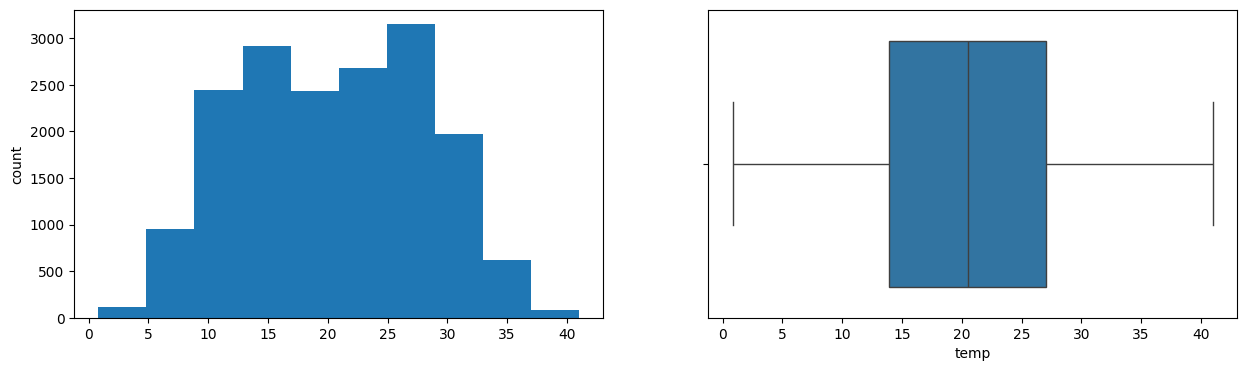

feel_temp
Skew : -0.09


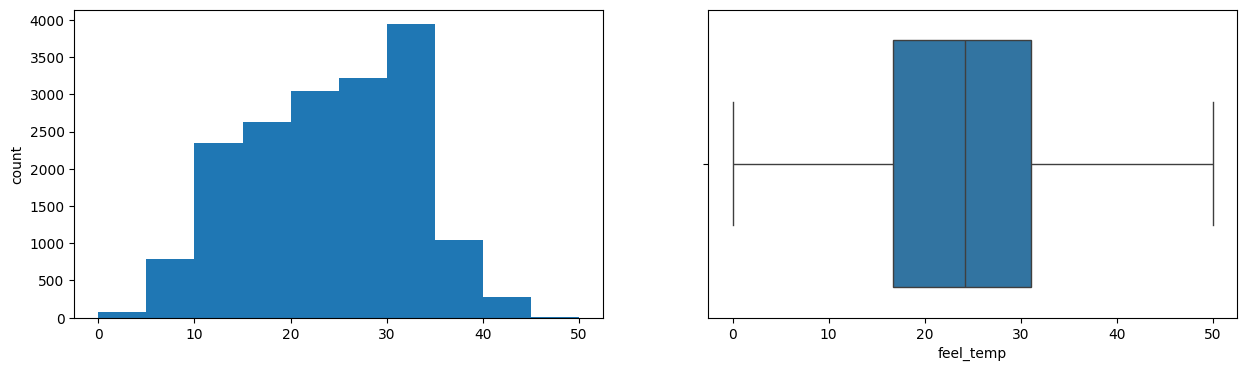

humidity
Skew : -0.11


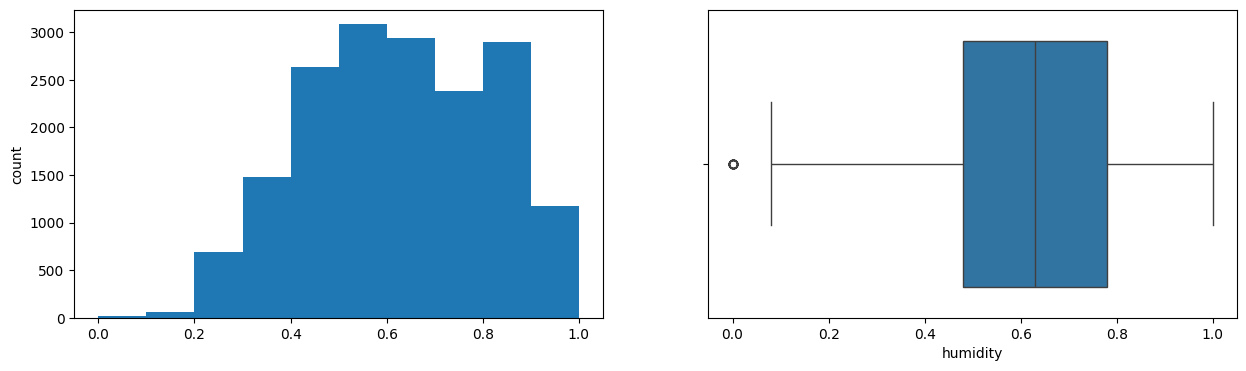

windspeed
Skew : 0.57


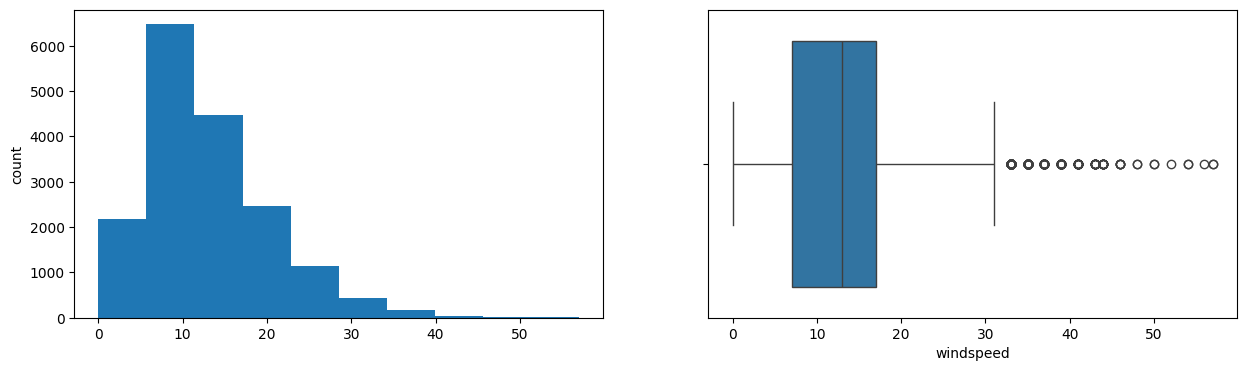

casual
Skew : 2.5


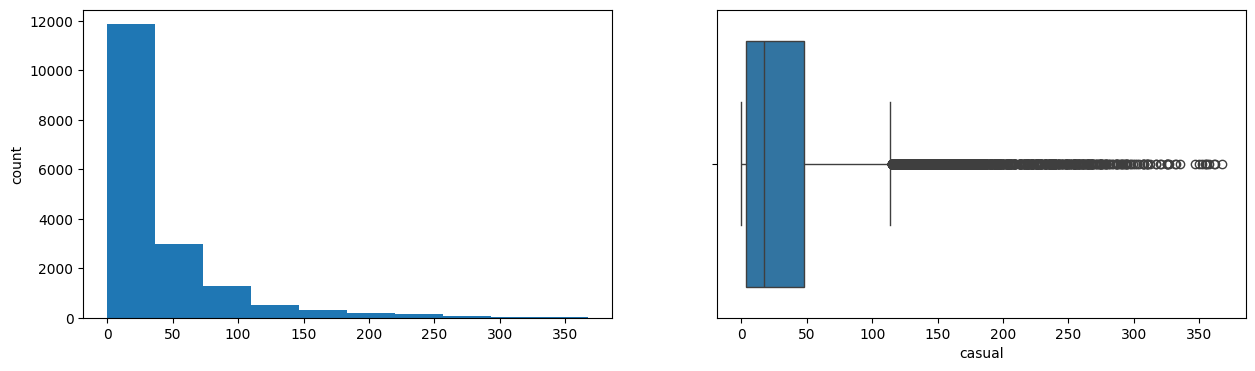

registered
Skew : 1.56


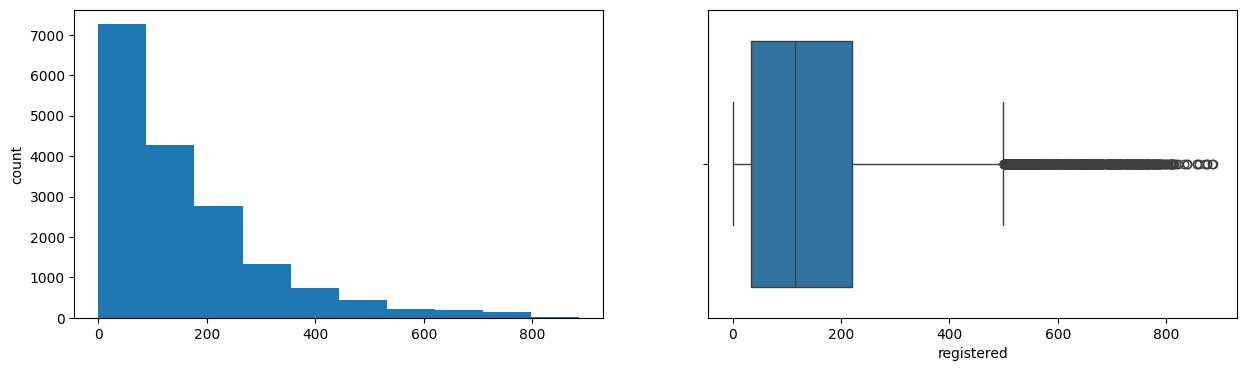

count
Skew : 1.28


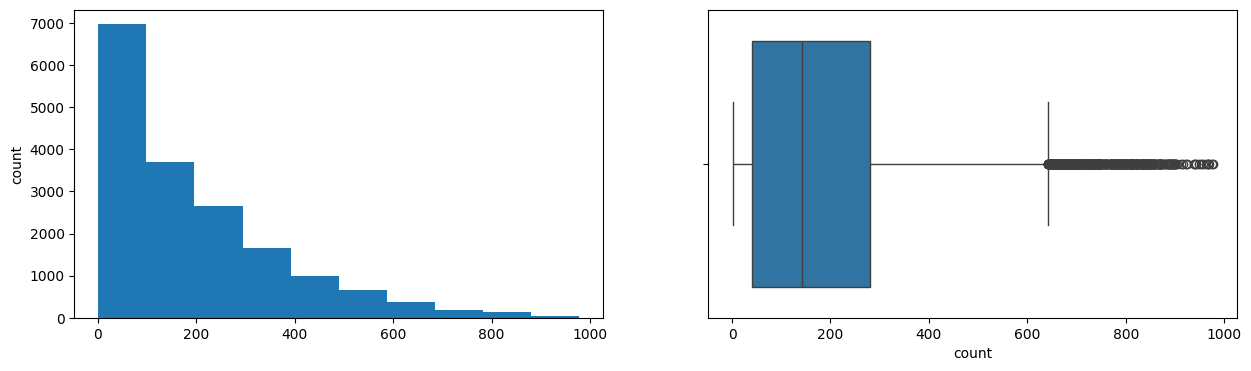

In [17]:
# EDA for univariate analysis of numerical variables
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

I have done a Univariate analysis using Histogram and  Box Plot for continuous variables. In the above fig, a histogram and box plot is used to show the pattern of the variables, as some variables have skewness and outliers.

Observations:
- The dataset shows a balanced distribution across the two years, with no transformation required. The year, month, hour, and weekday variables are uniformly distributed.
  
- The temperature and feels-like temperature variables are approximately normal distributions.
  
- Humidity is slightly left-skewed but overall well distributed, while windspeed shows right skewness, transformation would help reduce skewness. 
  
- Outliers observed in windspeed, casual, registered, and count will be handled appropriately during preprocessing.

/var/folders/01/gxzb8s_j6_ggc7n0lppzws100000gn/T/ipykernel_42414/2742883031.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='season', data=df, palette='Blues')
/var/folders/01/gxzb8s_j6_ggc7n0lppzws100000gn/T/ipykernel_42414/2742883031.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 1], x='holiday', data=df, palette='Blues')
/var/folders/01/gxzb8s_j6_ggc7n0lppzws100000gn/T/ipykernel_42414/2742883031.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1, 0], x='workingday', data=df, palette='

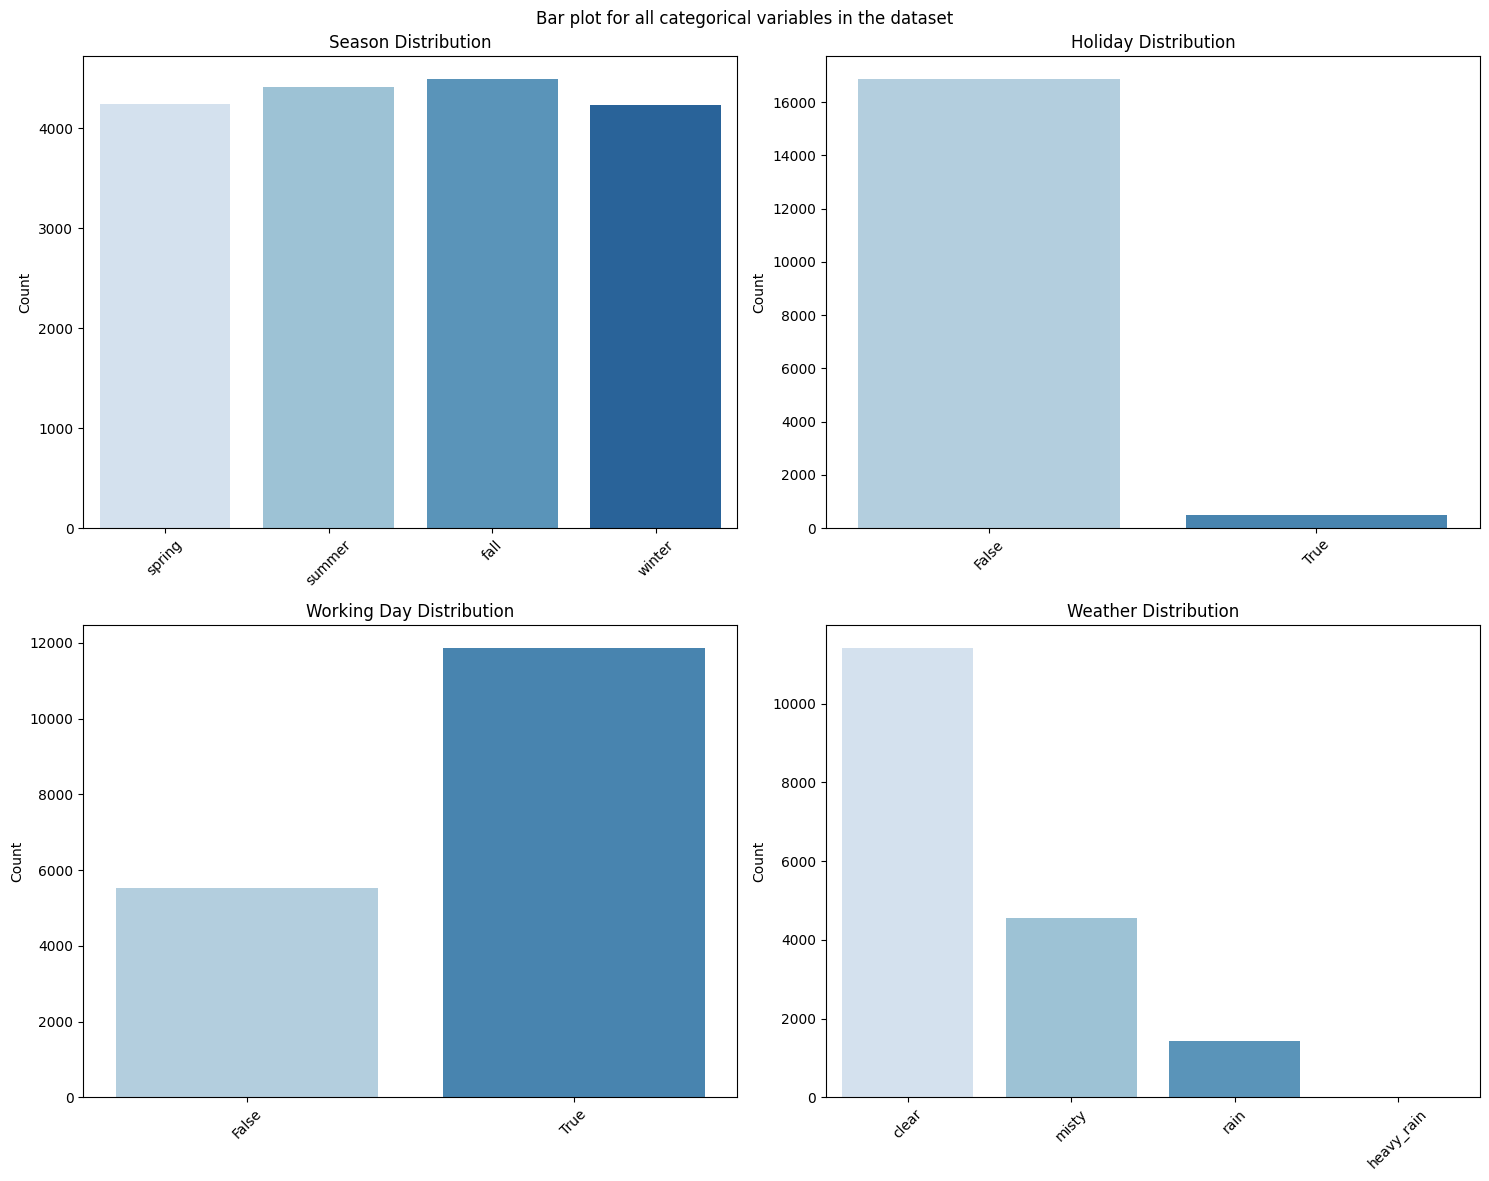

In [18]:
# EDA for Categorical Variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bar plot for all categorical variables in the dataset')

sns.countplot(ax=axes[0, 0], x='season', data=df, palette='Blues')
axes[0, 0].set_title('Season Distribution')

sns.countplot(ax=axes[0, 1], x='holiday', data=df, palette='Blues')
axes[0, 1].set_title('Holiday Distribution')

sns.countplot(ax=axes[1, 0], x='workingday', data=df, palette='Blues')
axes[1, 0].set_title('Working Day Distribution')

sns.countplot(ax=axes[1, 1], x='weather', data=df, palette='Blues')
axes[1, 1].set_title('Weather Distribution')

# Rotate x-axis labels for better visibility
for ax in axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [19]:
# calculate and display percentages for each categorical variable
categorical_cols = ['season', 'holiday', 'workingday', 'weather']

for col in categorical_cols:
    print(f"\n{col.upper()} Distribution:")
    percentages = (df[col].value_counts(normalize=True) * 100).round(2)
    print(percentages)



SEASON Distribution:
season
fall      25.87
summer    25.37
spring    24.41
winter    24.35
Name: proportion, dtype: float64

HOLIDAY Distribution:
holiday
False    97.12
True      2.88
Name: proportion, dtype: float64

WORKINGDAY Distribution:
workingday
True     68.27
False    31.73
Name: proportion, dtype: float64

WEATHER Distribution:
weather
clear         65.67
misty         26.15
rain           8.17
heavy_rain     0.02
Name: proportion, dtype: float64


From the count plot, we can have see: 
- The distribution across seasons is nearly uniform: Fall (25.87%), Summer (25.37%), Spring (24.41%), and Winter (24.35%), indicating that all seasons are well represented in the dataset.
  
- The majority of the records belong to non-holiday days (97.12%), while holiday days make up only 2.88%, showing that holidays are much fewer in number.
  
- Working days (68.27%) occur more frequently than non-working days (31.73%), suggesting that most of the data corresponds to regular working days.
  
- Clear weather (65.67%) is the most common, followed by misty (26.15%), rain (8.17%), and heavy rain (0.02%), showing that clear and mild weather conditions dominate the dataset.

Before we proceed to Bi-variate Analysis, Univariate analysis demonstrated the data pattern as some variables to be transformed.

<class 'pandas.core.frame.DataFrame'>
Index: 17377 entries, 0 to 17378
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          17377 non-null  object 
 1   year            17377 non-null  float64
 2   month           17377 non-null  float64
 3   hour            17377 non-null  float64
 4   holiday         17377 non-null  object 
 5   weekday         17377 non-null  float64
 6   workingday      17377 non-null  object 
 7   weather         17377 non-null  object 
 8   temp            17377 non-null  float64
 9   feel_temp       17377 non-null  float64
 10  humidity        17377 non-null  float64
 11  windspeed       17377 non-null  float64
 12  casual          17377 non-null  float64
 13  registered      17377 non-null  float64
 14  count           17377 non-null  float64
 15  humidity_log    17377 non-null  float64
 16  casual_log      17377 non-null  float64
 17  registered_log  17377 non-null  floa

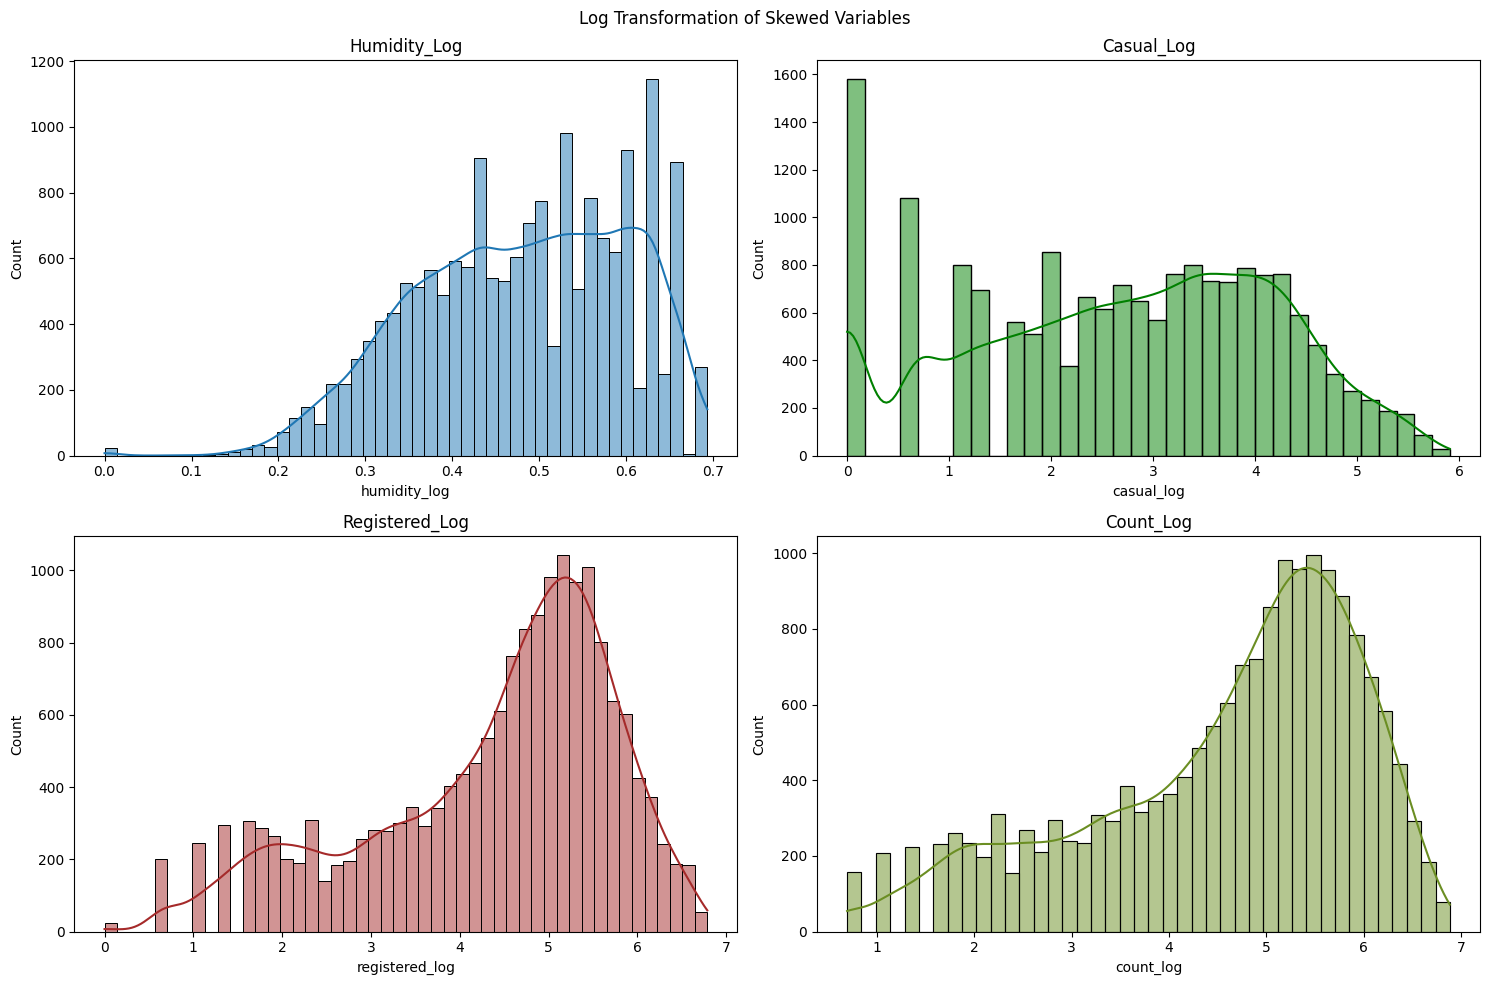

In [20]:
# log transformation of the selected columns
def log_transform(data, cols):
    for colname in cols:
        data[colname + '_log'] = np.log1p(data[colname])  
    data.info()

# columns to be transformed
cols_to_transform = ['humidity', 'casual', 'registered', 'count']
log_transform(df, cols_to_transform) # Apply the log transformation

# visualize the transformed features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Transformation of Skewed Variables')

sns.histplot(df['humidity_log'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Humidity_Log')

sns.histplot(df['casual_log'], ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Casual_Log')

sns.histplot(df['registered_log'], ax=axes[1, 0], kde=True, color='brown')
axes[1, 0].set_title('Registered_Log')

sns.histplot(df['count_log'], ax=axes[1, 1], kde=True, color='olivedrab')
axes[1, 1].set_title('Count_Log')

plt.tight_layout()
plt.show()

- The original humidity variable was mildly right-skewed, but after log transformation, it appears more balanced, with most observations concentrated between 0.3 and 0.6. 

- The casual variable showed significant right skew. After log transformation, the distribution became more symmetric. 
  
- The registered variable had a heavy tail before transformation. The log transformation successfully normalized the distribution, showing a smoother and more bell-shaped curve centered around mid-level user counts.
  
- The overall count now forms a smoother curve, with most data points concentrated near the middle. The pattern indicates a better balance between lower and higher values after transformation.

#### EDA Bivariate Analysis

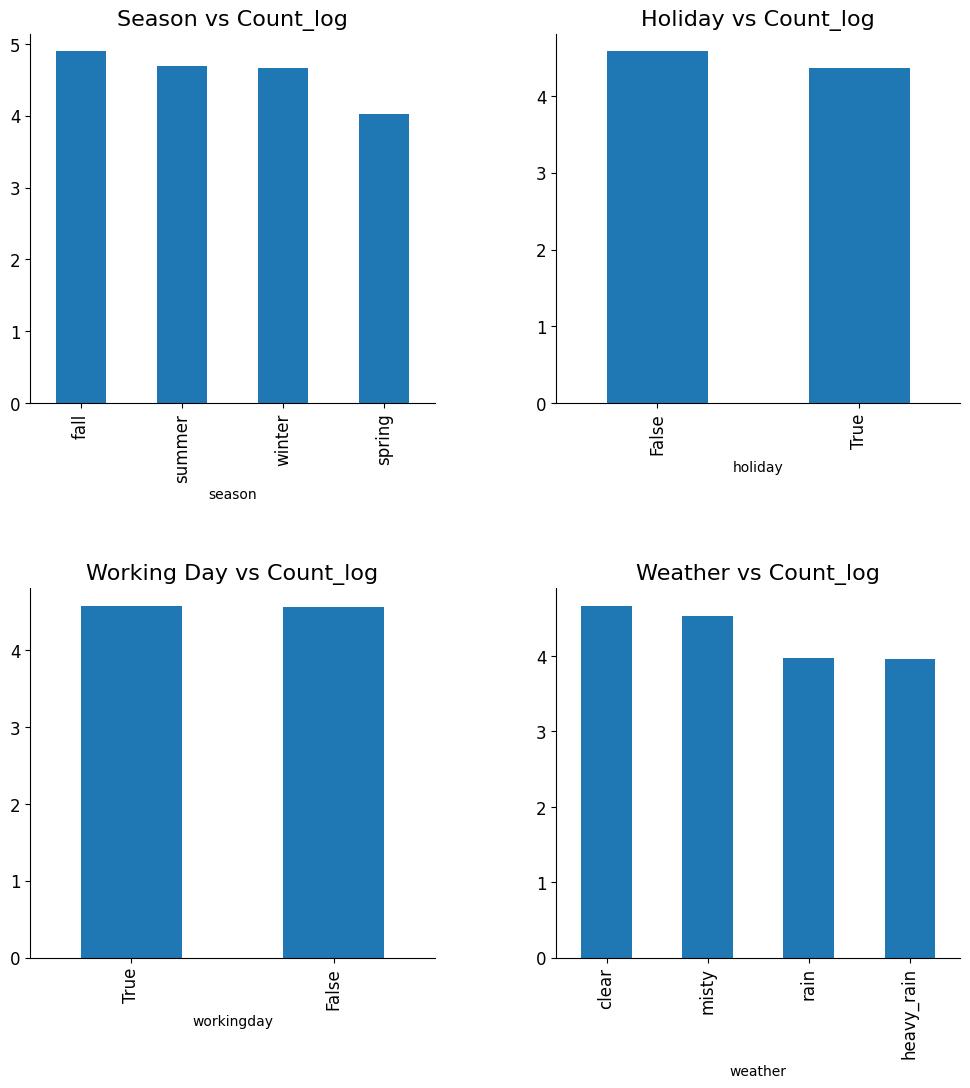

In [21]:
# EDA Bivariate Analysis showing relationship between categorical variables and count_log
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

df.groupby('season')['count_log'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][0], fontsize=12)
axarr[0][0].set_title("Season vs Count_log", fontsize=16)

df.groupby('holiday')['count_log'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][1], fontsize=12)
axarr[0][1].set_title("Holiday vs Count_log", fontsize=16)

df.groupby('workingday')['count_log'].mean().sort_values(ascending=False).plot.bar(ax=axarr[1][0], fontsize=12)
axarr[1][0].set_title("Working Day vs Count_log", fontsize=16)

df.groupby('weather')['count_log'].mean().sort_values(ascending=False).plot.bar(ax=axarr[1][1], fontsize=12)
axarr[1][1].set_title("Weather vs Count_log", fontsize=16)

plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.3)
sns.despine()

Observations: 
- The number of rides appears highest during fall, followed closely by summer and winter, while spring shows the lowest average count. This indicates that ridership tends to increase during warmer months and decrease in early spring.

- The average count is slightly lower on holidays compared to non-holidays meaning only fewer people use bikes on holidays than on regular working days.

- The number of rides on working days and non-working days seems quite similar, with only a minimal difference, implying that both work and leisure usage contribute evenly to the total ridership.

- The count is highest when the weather is clear, and it gradually decreases in misty, rainy, and heavily rainy conditions, meaning that the the average count_log which represents total rides decreases. As the weather condition worsens, the average number of rides goes down.

#### Outlier Detection 

Outlier counts per numerical feature (|z| > 3):


casual        467
registered    371
count         244
windspeed     107
humidity       22
feel_temp       1
temp            0
dtype: int64

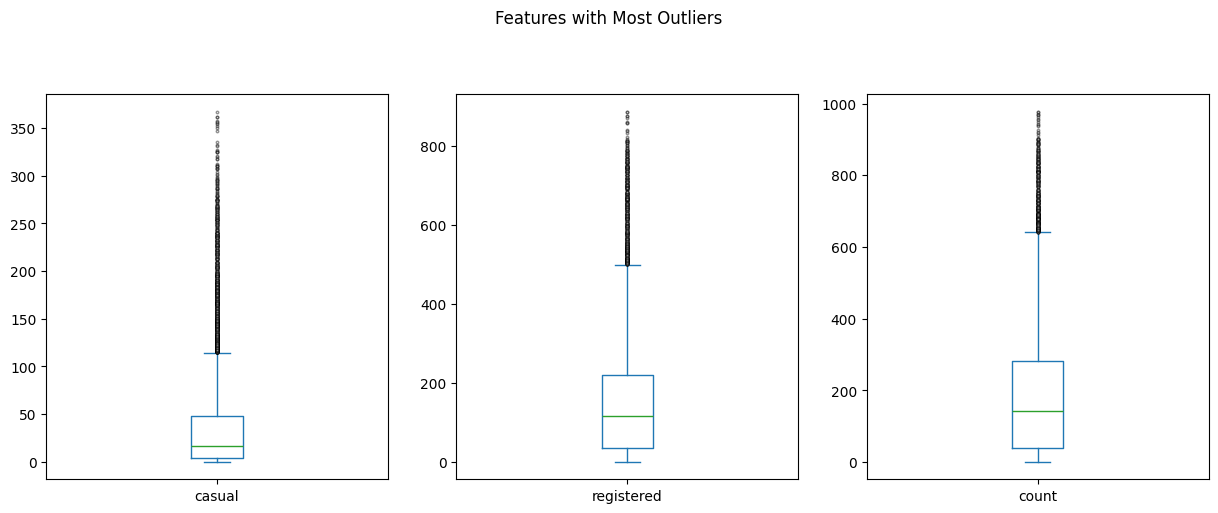

In [22]:
# outlier detection on features 
z_scores = df[num_cols].apply(lambda col: zscore(col, nan_policy="omit"))
outlier_count = (np.abs(z_scores) > 3).sum()

print("Outlier counts per numerical feature (|z| > 3):")
display(outlier_count.sort_values(ascending=False).head(10))

# Visualize the top 3 features with most outliers
top_outlier_features = outlier_count.sort_values(ascending=False).head(3).index

subset_numeric = df[top_outlier_features].apply(pd.to_numeric, errors="coerce").dropna(how="all")

# subset_numeric.plot(kind="box", subplots=True, layout=(1, 3), figsize=(15, 5), sharey=False)
# plt.suptitle("Features with most outliers", y=1.0)
# plt.show()

subset_numeric.plot(
    kind="box",
    subplots=True,
    layout=(1, 3),
    figsize=(15, 5),
    sharey=False,
    flierprops=dict(marker='o', markersize=1.8, markerfacecolor='lightgray', alpha=0.4)
)
plt.suptitle("Features with Most Outliers", y=1.05)
plt.show()

Observations: 

The boxplots show that ‘casual’, ‘registered’, and ‘count’ have a high number of outliers, visible points as seen in the boxplot. These features have more variation compared to the others. In contrast, other numerical variables show minimal or no outliers.

#### EDA Multivariate Analysis

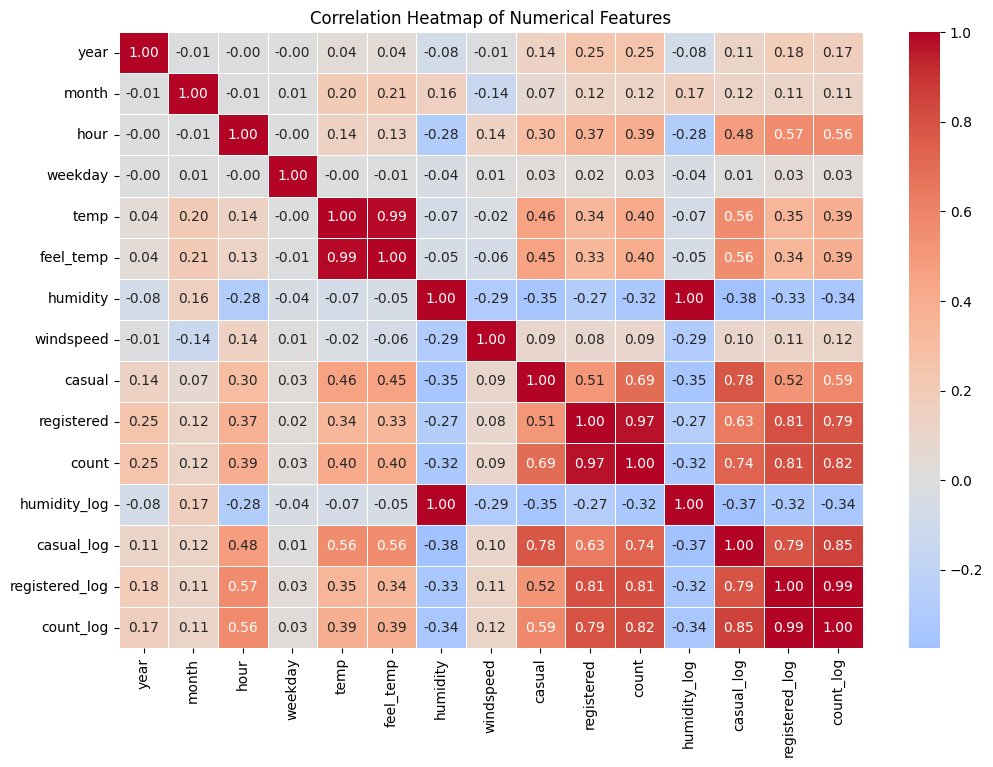

In [23]:
# correlation heatmap of features
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Observations: 

From the correlation heatmap, it is clear that temp and feel_temp are highly correlated, which is expected since both describe temperature conditions. The variables casual, registered, and count also show strong positive correlations with each other. Their log-transformed versions (casual_log, registered_log, and count_log) follow the same pattern.
In contrast, humidity has a weak negative correlation with these variables, while year, month, weekday, and windspeed show little to no correlation. with ridership.

## Task 1 - Comparing linear and non-linear DR

In [24]:
# split the data into features and target variable
X = df_encoded.drop(columns=['count'])
y = df['count_log']

In [25]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# define which columns are categorical and which are numeric
# identify numeric columns (ignore dummy 0/1 columns)
numeric_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]

# scale only numeric columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Feature matrix shape (train):", X_train_scaled.shape)
print("Feature matrix shape (test):", X_test_scaled.shape)


Feature matrix shape (train): (13901, 55)
Feature matrix shape (test): (3476, 55)


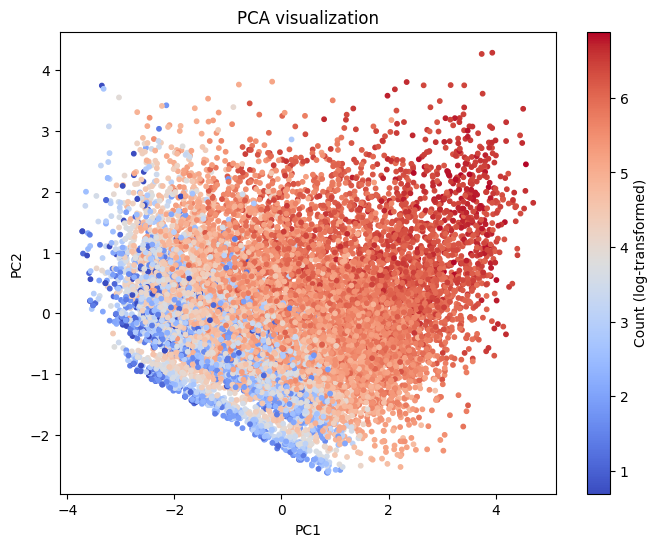

[0.30489527 0.12943863]


In [27]:
# apply PCA 
pca = PCA(n_components=2) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) 

# plot PCA 
plt.figure(figsize=(8,6)) 
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=10) 
plt.title("PCA visualization") 
plt.xlabel("PC1") 
plt.ylabel("PC2") 
plt.colorbar(label='Count (log-transformed)') 
plt.show()

print(pca.explained_variance_ratio_)


Observations: 

The PCA plot shows that the data points form a dense, cluster with smooth color transitions from blue to red. The blue points on the lower left side represent smaller log-transformed bike rental counts, while the red points on the right indicate higher counts. This color change happens smoothly and gradually. Most of the points are gathered in the middle, and the colors gradually shift from blue to red across the plot. The first component explains about 30% of the total variance, and the second explains about 13%.

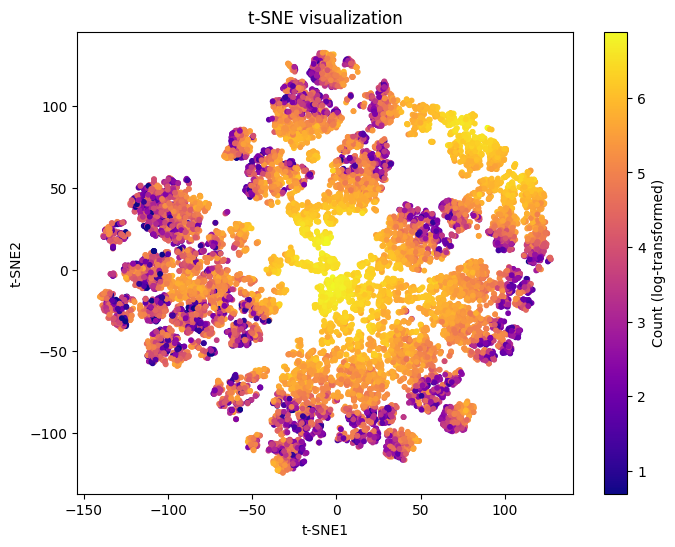

In [29]:
# apply t-SNE
tsne = TSNE(
    n_components=2,       
    perplexity=40,
    max_iter=5000,
    learning_rate=200,
    random_state=42
)

X_train_tsne = tsne.fit_transform(X_train_scaled)


plt.figure(figsize=(8,6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='plasma', s=10)
plt.title("t-SNE visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='Count (log-transformed)')
plt.show()


Observations: 

So unlike the PCA, the t-SNE keep similar points close together. The t-SNE plot shows that the data points are divided into several small clusters spread across the plot. The yellow areas in the center represent higher log-transformed bike rental counts, while the darker purple areas on the outside show lower counts. The points that are close to each other have similar feature values, meaning t-SNE has grouped similar data together. 

In [30]:
# train the model 
def cal_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def random_forest_model(X_train, X_test, y_train, y_test, text):
    forest = RandomForestRegressor(
        n_estimators=120, random_state=42, min_samples_split=3, n_jobs=-1
    )
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    # Evaluation metrics
    r2_val = r2_score(y_test, y_pred)
    mae_val = mean_absolute_error(y_test, y_pred)
    rmse_val = cal_rmse(y_test, y_pred)

    print(f"\n{text}")
    print(f"R2 Score : {r2_val:.4f}")
    print(f"MAE      : {mae_val:.4f}")
    print(f"RMSE     : {rmse_val:.4f}")

    # # Residual plot
    # residuals = y_test - y_pred
    # plt.figure(figsize=(6,4))
    # plt.scatter(y_pred, residuals, alpha=0.5, color='teal')
    # plt.axhline(0, color='darkred', linestyle='--', linewidth=1.5)
    # plt.title(f"Residual Distribution ({text})")
    # plt.xlabel("Predicted count")
    # plt.ylabel("Residual (True - Predicted)")
    # plt.tight_layout()
    # plt.show()

random_forest_model(X_train_pca, X_test_pca, y_train, y_test, "PCA")
random_forest_model(X_train_tsne, X_train_tsne, y_train, y_train, "t-SNE")
random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, "Original_data")



PCA
R2 Score : 0.5683
MAE      : 0.6463
RMSE     : 0.9217

t-SNE
R2 Score : 0.9713
MAE      : 0.1500
RMSE     : 0.2409

Original_data
R2 Score : 1.0000
MAE      : 0.0044
RMSE     : 0.0094


Observations: 

The model performed well on the original data, achieving almost perfect performance (R²= 1.0000, MAE= 0.0045, RMSE= 0.0095).
Next, t-SNE captured non-linear patterns effectively and outperformed PCA, achieving strong performance (R²= 0.9665, MAE= 0.1677, RMSE= 0.2601). Lastly, PCA showed a significant drop in performance (R²= 0.4920, MAE= 0.7275, RMSE= 0.9999), indicating that linear dimensionality reduction failed to retain important predictive information.


## Task 2 - Visualizing with SOM

In [31]:
# import arff file
arff_file = arff.loadarff('mnist_784.arff')

In [32]:
data = pd.DataFrame(arff_file[0])

In [33]:
data.shape

(70000, 785)

In [34]:
# separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].astype(int).values

In [35]:
# use a smaller subset for faster computation
X_small = X[:5000]
y_small = y[:5000]

# normalize features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_small)

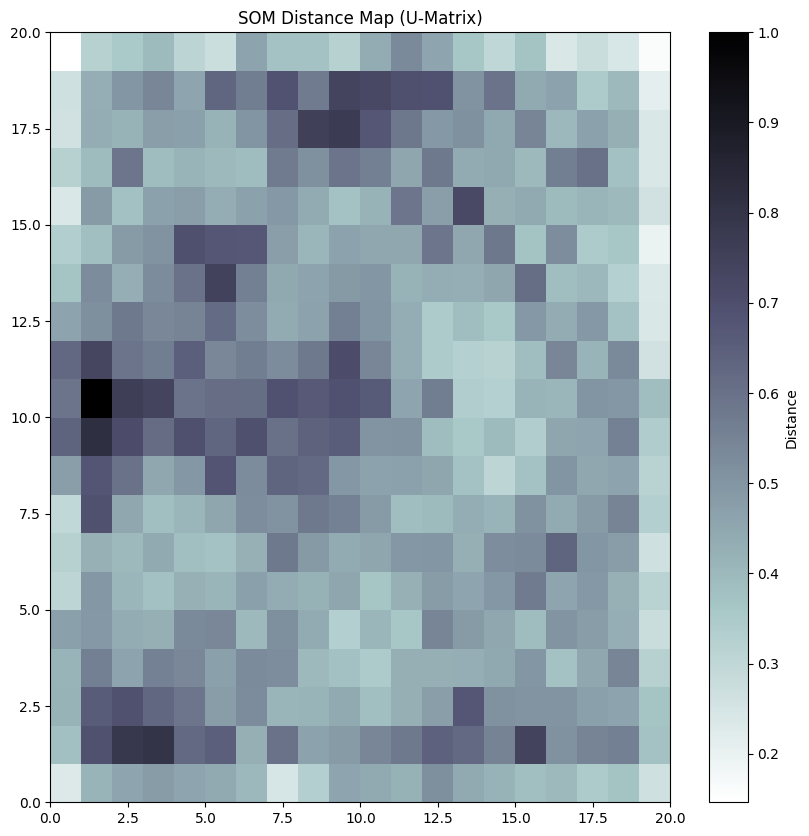

In [36]:
# initialize SOM 
som_shape = (20, 20)
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=1000)

# visualize SOM
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  
plt.colorbar(label='Distance')
plt.title('SOM Distance Map (U-Matrix)')
plt.show()

Observations: 

The U-Matrix shows the distance between nearby neurons. Light areas mean there is a big distance, which shows the borders between groups.
Dark areas mean small distances, where the data points are similar. In this plot, we can see that the SOM has formed several clear clusters. 


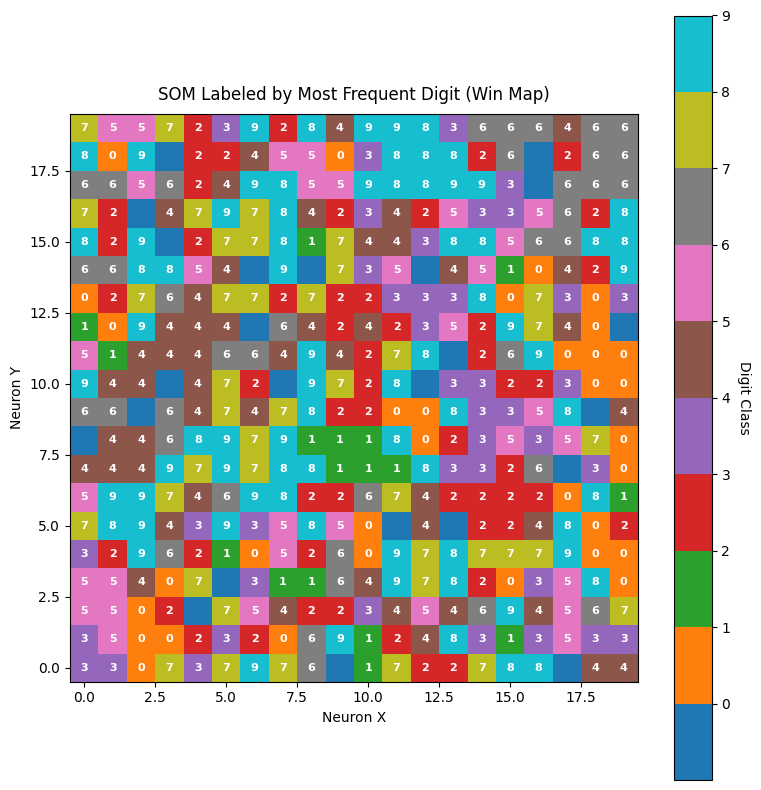

In [37]:
# train SOM
som_x, som_y = 20, 20   
som = MiniSom(som_x, som_y, X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 1000)

# compute winners for each data point
winners = [som.winner(x) for x in X_scaled]

# create label grid based on majority class per neuron
label_grid = np.full((som_x, som_y), -1, dtype=int)
for i in range(som_x):
    for j in range(som_y):
        indices = [k for k, w in enumerate(winners) if w == (i, j)]
        if indices:
            label_grid[i, j] = Counter(y_small[indices]).most_common(1)[0][0]

# plot SOM
plt.figure(figsize=(8, 8))
im = plt.imshow(label_grid.T, cmap="tab10", origin="lower")

plt.title("SOM Labeled by Most Frequent Digit (Win Map)", fontsize=12, pad=10)
plt.xlabel("Neuron X", fontsize=10)
plt.ylabel("Neuron Y", fontsize=10)

# add colorbar
cbar = plt.colorbar(im, ticks=range(10))
cbar.set_label("Digit Class", rotation=270, labelpad=15)
cbar.ax.set_yticklabels([str(i) for i in range(10)])

# overlay labels on the map
for i in range(som_x):
    for j in range(som_y):
        label = label_grid[i, j]
        if label >= 0:
            plt.text(i, j, str(label), ha="center", va="center",
                     color="white", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()

Observations: 

The labeled map shows the most common digit in each cell. Each color represents one digit, and the number in the cell tells which digit it is. In this plot, the digits are spread across the map, but we can still notice that some areas have repeating numbers, meaning that certain digits appear together more often. This shows that the SOM can organize digits with similar pixel patterns close to each other, even if the clusters are not fully separated.